In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [ ]:
# Initialize Global Settings
plt.rc("font", size=14) # Set Font Size
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [ ]:
# Read in Data and convert to pandas data frame
data_raw = pd.read_csv('hepatitis.csv',header = 0,na_values=[" "])
data = pd.DataFrame(data_raw)
#data

In [ ]:
# View Descriptive Statistics
data.describe()

,class,age,bilirubin,alkphosphate,sgot,albumin,protime
count,155.000000,155.000000,149.000000,126.000000,151.00000,139.000000,87.000000
mean,0.793548,41.200000,1.427517,105.325397,85.89404,3.817266,62.091954
std,0.406070,12.565878,1.212149,51.508109,89.65089,0.651523,22.896446
min,0.000000,7.000000,0.300000,26.000000,14.00000,2.100000,0.000000
25%,1.000000,32.000000,0.700000,74.250000,31.50000,3.400000,46.000000
50%,1.000000,39.000000,1.000000,85.000000,58.00000,4.000000,62.000000
75%,1.000000,50.000000,1.500000,132.250000,100.50000,4.200000,76.500000
max,1.000000,78.000000,8.000000,295.000000,648.00000,6.400000,100.000000


In [ ]:
# Get count of missing values by field
data.isnull().sum()[data.isnull().sum() > 0]

bilirubin        6
alkphosphate    29
sgot             4
albumin         16
protime         68
dtype: int64

In [ ]:
#Check if columns containing null values are normally distributed
column_null = data.columns[data.isnull().any()].tolist()
for c in column_null:
    print(c,':', stats.normaltest(data[c],nan_policy='omit'))

bilirubin : NormaltestResult(statistic=113.48119911198776, pvalue=2.279663327890759e-25)
alkphosphate : NormaltestResult(statistic=35.05145105149456, pvalue=2.447226195826819e-08)
sgot : NormaltestResult(statistic=129.32332921051136, pvalue=8.275531026340891e-29)
albumin : NormaltestResult(statistic=5.99229336985181, pvalue=0.04997928372423092)
protime : NormaltestResult(statistic=1.4155143799474865, pvalue=0.4927480994548745)


In [ ]:
# Replace missing values in protime column with random values from normal distribution
np.random.seed(31309) # Set the random seed for reproducibility
mu = data["protime"].mean()         # Calculate mean
sigma = data["protime"].std()       # Calculate standard deviation
a = data["protime"].isnull()        # Identify missing values
norm_dist = np.random.normal(mu, sigma, a.sum()) # Generate Random replacements
half = min(data["protime"]) / 2
if(np.isnan(half)):
    half = norm_dist
print("protime:", half)
data["protime"].loc[np.isnan(data["protime"])] = half # Insert the random replacements
data.isnull().sum()[data.isnull().sum() > 0]

protime: [ 71.93162287  67.4715456   10.8414288   69.7531968   79.5826949
  67.81746824  57.0469538   77.6477085  105.24334199  71.44086608
  27.02594956  33.41015447  62.59388628  64.72740928  79.15838382
  74.80134606  73.40505557  70.75819194  99.5296475   56.74162847
  94.50406008  55.93824995  87.80437518  54.13171209  39.7320422
  84.93758509 108.17805478  24.01815975  50.61141422  57.53733777
  57.73668824  50.79210559  80.54368849  77.52296364  28.61731932
  38.1624156   62.55207257  73.26902173  49.71549611 108.13250514
  57.57665926  71.84902758  59.1485531   44.92131084  58.13273038
 110.47190314 111.33540781  61.6068432   67.7647404   26.95708053
  77.34376753  76.57825533  52.00437885  57.53789551  40.24986514
  96.94416295  82.07271719  57.80805521 121.91803954  55.31283263
  55.50369809  91.24069095  82.69204949  53.40435311  55.77506958
  55.54672983  51.48438716  78.34164501]


bilirubin        6
alkphosphate    29
sgot             4
albumin         16
dtype: int64

In [ ]:
#Replace missing values for non normal distribution with random samples 
data = data.apply(lambda x: np.where(x.isnull(), x.dropna().sample(len(x), replace=True), x))
#data

In [ ]:
# Check for missing values after replacement
data.isnull().sum()[data.isnull().sum() > 0]

Series([], dtype: int64)

In [ ]:
# Means of continous variables by Class
data.groupby('class').mean()

,age,bilirubin,alkphosphate,sgot,albumin,protime
class,,,,,,
0,46.593750,2.450000,112.593750,95.906250,3.371875,50.323245
1,39.796748,1.134146,99.577236,81.853659,3.965041,67.549144


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   class           155 non-null    int64  
 1   age             155 non-null    int64  
 2   sex             155 non-null    object 
 3   steroid         155 non-null    object 
 4   antivirals      155 non-null    object 
 5   fatigue         155 non-null    object 
 6   malaise         155 non-null    object 
 7   anorexia        155 non-null    object 
 8   liverbig        155 non-null    object 
 9   liverfirm       155 non-null    object 
 10  spleenpalpable  155 non-null    object 
 11  spiders         155 non-null    object 
 12  ascites         155 non-null    object 
 13  varices         155 non-null    object 
 14  bilirubin       155 non-null    float64
 15  alkphosphate    155 non-null    float64
 16  sgot            155 non-null    float64
 17  albumin         155 non-null    flo

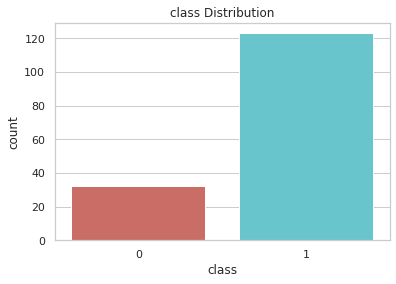

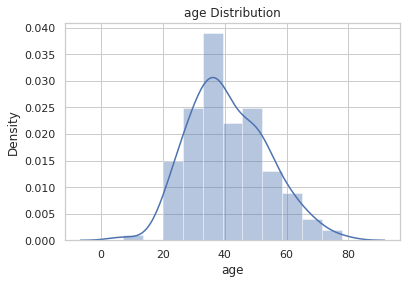

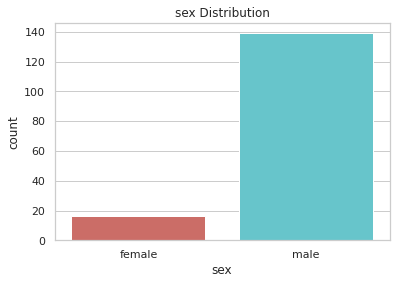

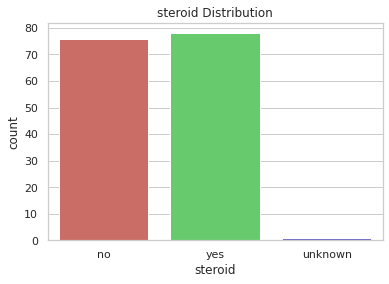

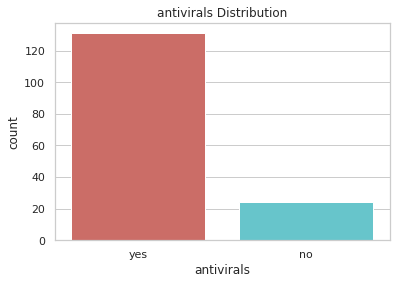

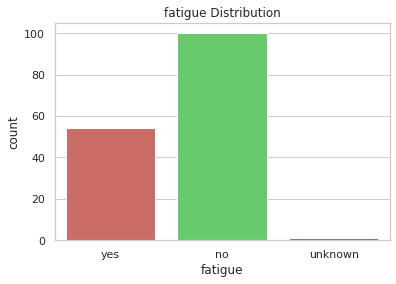

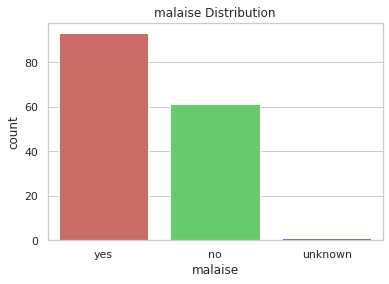

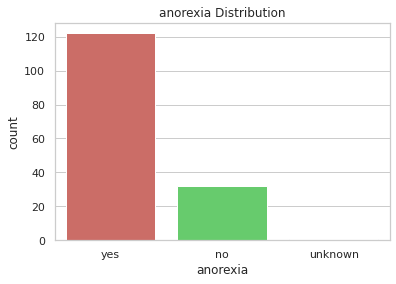

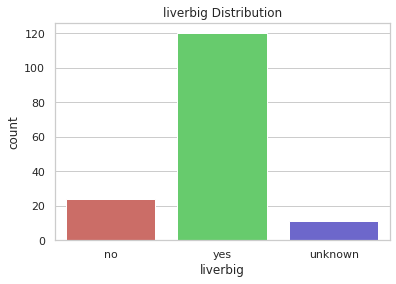

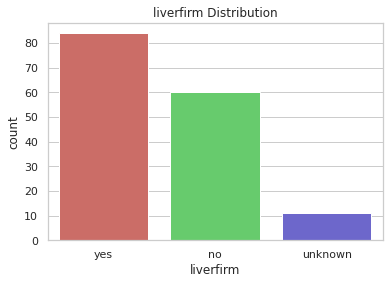

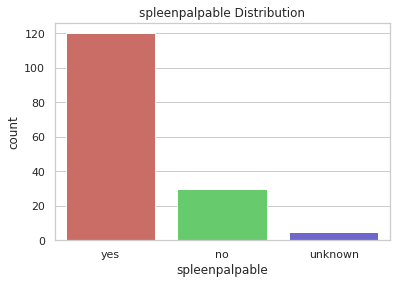

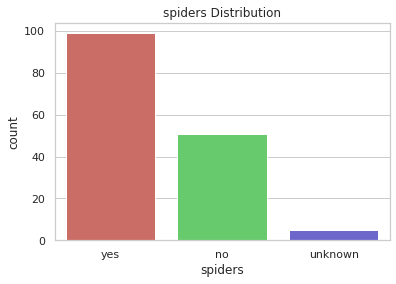

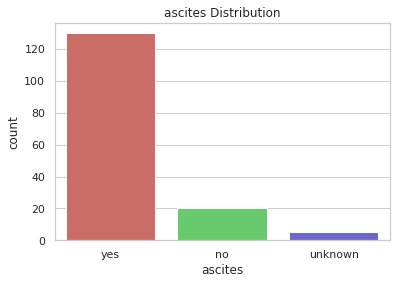

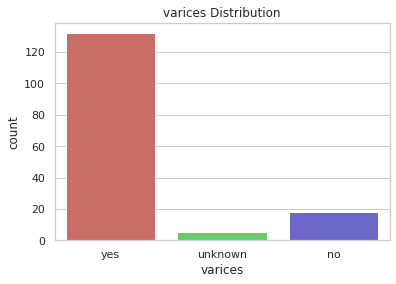

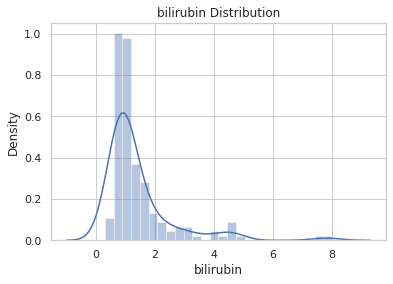

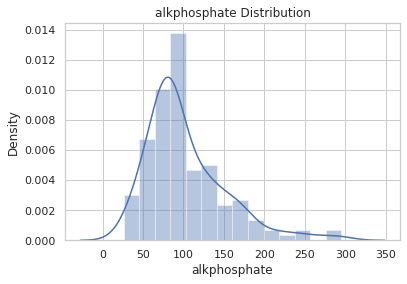

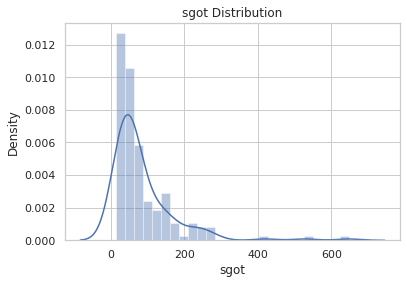

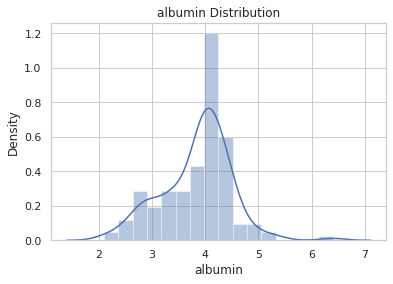

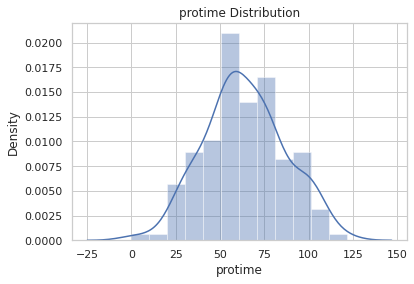

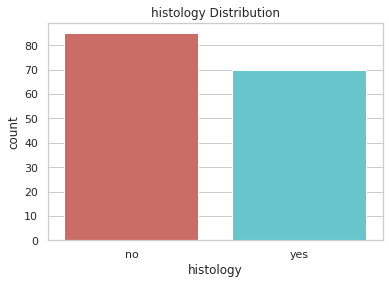

In [ ]:
#Plotting
for field in data.columns.values: # Loop through fields
    if(len(data[field].unique()) <= 3): # If there are 3 or fewer unique values
        sns.countplot(x=field, data = data, palette = 'hls') # Produce a countplot
    else: 
        sns.distplot(data[field].dropna()) # Produce a distplot
    plt.title(field + " Distribution") # Add a title
    plt.show() # Show the plot

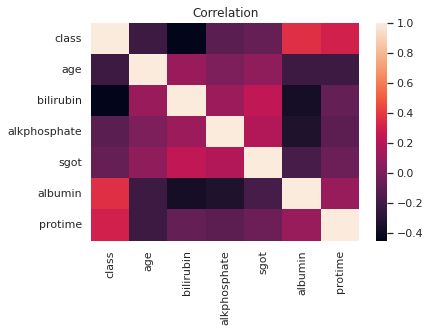

In [ ]:
# Plot Correlation
x=data.corr()
sns.heatmap(x)
plt.title("Correlation")
plt.show()

In [ ]:
# View correlations with class
x['class'].sort_values(ascending=False)

class           1.000000
albumin         0.370924
protime         0.306837
sgot           -0.064281
alkphosphate   -0.108188
age            -0.219647
bilirubin      -0.447556
Name: class, dtype: float64

In [ ]:
#Creating Dummies
data2=pd.get_dummies(data,columns=['sex','steroid','antivirals','fatigue','malaise','anorexia','liverbig',
                                   'liverfirm','spleenpalpable','spiders','ascites','varices','histology'])
print("Data shape:", data2.shape)
for i,j in enumerate(list(data2.columns)):
    print (str(i) + ": " + j)

Data shape: (155, 43)
0: class
1: age
2: bilirubin
3: alkphosphate
4: sgot
5: albumin
6: protime
7: sex_female
8: sex_male
9: steroid_no
10: steroid_unknown
11: steroid_yes
12: antivirals_no
13: antivirals_yes
14: fatigue_no
15: fatigue_unknown
16: fatigue_yes
17: malaise_no
18: malaise_unknown
19: malaise_yes
20: anorexia_no
21: anorexia_unknown
22: anorexia_yes
23: liverbig_no
24: liverbig_unknown
25: liverbig_yes
26: liverfirm_no
27: liverfirm_unknown
28: liverfirm_yes
29: spleenpalpable_no
30: spleenpalpable_unknown
31: spleenpalpable_yes
32: spiders_no
33: spiders_unknown
34: spiders_yes
35: ascites_no
36: ascites_unknown
37: ascites_yes
38: varices_no
39: varices_unknown
40: varices_yes
41: histology_no
42: histology_yes


In [ ]:
#Drop Unknown Columns
unk_idx = [i for i, col in enumerate(data2.columns) if col.endswith('unknown')] # Find columns that end with 'unknown'
data2.drop(data2.columns[[unk_idx]], axis = 1, inplace = True)

In [ ]:
data2.shape

(155, 33)

In [ ]:
data2.columns

Index(['class', 'age', 'bilirubin', 'alkphosphate', 'sgot', 'albumin',
       'protime', 'sex_female', 'sex_male', 'steroid_no', 'steroid_yes',
       'antivirals_no', 'antivirals_yes', 'fatigue_no', 'fatigue_yes',
       'malaise_no', 'malaise_yes', 'anorexia_no', 'anorexia_yes',
       'liverbig_no', 'liverbig_yes', 'liverfirm_no', 'liverfirm_yes',
       'spleenpalpable_no', 'spleenpalpable_yes', 'spiders_no', 'spiders_yes',
       'ascites_no', 'ascites_yes', 'varices_no', 'varices_yes',
       'histology_no', 'histology_yes'],
      dtype='object')

In [ ]:
#Building Logistic Regression Model for selecting important features using Recursive Feature Elimination(RFE)
A = data2.iloc[:,1:]
b = data2.iloc[:,0]
classifier = LogisticRegression(random_state = 5)
from sklearn.feature_selection import RFE
rfe = RFE(classifier,n_features_to_select=29)
classifier = rfe.fit(A, b)
print("Num Features: %d" % (classifier.n_features_,))
print("Selected Features: %s" % (classifier.support_,))
print("Feature Ranking: %s" % (classifier.ranking_,))
data2.shape
asdf = (classifier.support_,)
q = asdf[0].tolist()
#print(q)
dip = []        
for i, j in enumerate (q) :
    if j == False:
        dip.append(i+1)
data2 = data2.drop(data2.columns[dip], axis=1)
data2.columns

Num Features: 29
Selected Features: [False  True False False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
Feature Ranking: [2 1 4 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


Index(['class', 'bilirubin', 'albumin', 'protime', 'sex_female', 'sex_male',
       'steroid_no', 'steroid_yes', 'antivirals_no', 'antivirals_yes',
       'fatigue_no', 'fatigue_yes', 'malaise_no', 'malaise_yes', 'anorexia_no',
       'anorexia_yes', 'liverbig_no', 'liverbig_yes', 'liverfirm_no',
       'liverfirm_yes', 'spleenpalpable_no', 'spleenpalpable_yes',
       'spiders_no', 'spiders_yes', 'ascites_no', 'ascites_yes', 'varices_no',
       'varices_yes', 'histology_no', 'histology_yes'],
      dtype='object')

In [ ]:
#Building model after feature selection
X = data2.iloc[:,1:]
y = data2.iloc[:,0]
#print(type(X))
#print(y)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.25,random_state = 5)
#X_train.shape
#X_test.shape
#y_train.shape
#y_test.shape

In [ ]:
#Building Logistic Regression Model
classifier = LogisticRegression(random_state = 5)

classifier.fit(X_train, y_train)

#Predicting and Confusion Matrix
y_pred = classifier.predict(X_test)
y_pred_prob = classifier.predict_proba(X_test)[:, 1]
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[ 4  3]
 [ 1 31]]


In [ ]:
#Caluclating Accuracy
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(classifier.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.90


In [ ]:
#Caluclating Precision and F-score
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.57      0.67         7
           1       0.91      0.97      0.94        32

    accuracy                           0.90        39
   macro avg       0.86      0.77      0.80        39
weighted avg       0.89      0.90      0.89        39



In [ ]:
#Weights of each feature
classifier.coef_

array([[-0.49925245,  0.33972468,  0.0302096 ,  0.87226452, -0.86168851,
        -0.18956743,  0.19253062,  0.00206499,  0.00851103, -0.76451683,
         0.61500578, -0.4734684 ,  0.32395736,  0.24517604, -0.39468708,
         0.49157391,  0.29638055,  0.6393626 ,  0.12479453, -0.76794349,
         0.60688278, -0.74376131,  0.5827006 , -0.54320244,  0.38214173,
         0.06233167, -0.22339237,  0.01379552, -0.0032195 ]])

In [ ]:
#K-fold cross validation
from sklearn import model_selection
fold = model_selection.KFold(n_splits=10, shuffle=True, random_state=7)
scores = cross_val_score(classifier, X, y, cv=fold)
print(scores)
print('average accuracy: {}'.format(scores.mean()))

[0.8125     0.625      0.9375     0.9375     1.         0.8
 0.86666667 0.66666667 0.93333333 0.8       ]
average accuracy: 0.8379166666666666


Area under ROC: 0.7723214285714286


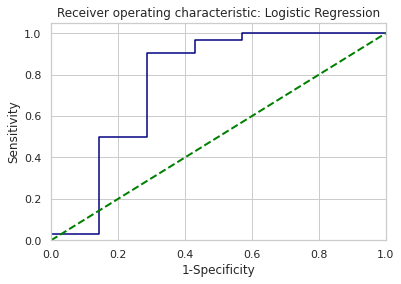

In [ ]:
#Define a function to draw ROC
def drawROC(y_test, y_pred_prob, cl_name):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(2):
        fpr[i], tpr[i], th_ = roc_curve(y_test, y_pred_prob)
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    print("Area under ROC:",roc_auc_score(y_test, y_pred_prob))
    plt.figure()
    plt.plot(fpr[1], tpr[1], color = 'navy')
    plt.plot([0, 1], [0, 1], color='green', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1-Specificity')
    plt.ylabel('Sensitivity')
    plt.title('Receiver operating characteristic: '+cl_name)
    plt.show()

#ROC of logistic Regression
drawROC(y_test, y_pred_prob, 'Logistic Regression')

Text(0.5, 1.03, 'Confusion Matrix for Logistic Regression')

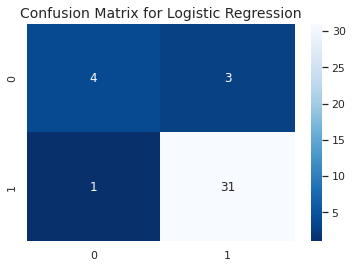

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
sns.set_style("white")
y_pred_classifier = classifier.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred_classifier)
sns.heatmap(cf_matrix, annot=True, cmap="Blues_r")
plt.title("Confusion Matrix for Logistic Regression", fontsize=14, fontname="Helvetica", y=1.03)

In [ ]:
#Support Vector Machines
from sklearn import svm

svc = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)

y_pred = svc.predict(X_test)
from sklearn.metrics import confusion_matrix
confusion_matrix1 = confusion_matrix(y_test, y_pred)
print(confusion_matrix1)

[[ 5  2]
 [ 3 29]]


In [ ]:
#Caluclating Accuracy
print('Accuracy of SVM classifier on test set: {:.2f}'.format(svc.score(X_test, y_test)))

Accuracy of SVM classifier on test set: 0.87


Text(0.5, 1.03, 'Confusion Matrix for Logistic Regression')

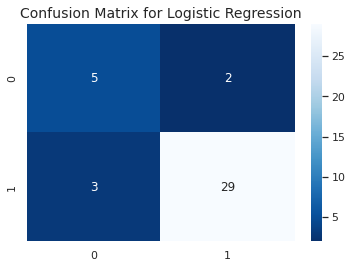

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
sns.set_style("white")
y_pred_svc = svc.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred_svc)
sns.heatmap(cf_matrix, annot=True, cmap="Blues_r")
plt.title("Confusion Matrix for Logistic Regression", fontsize=14, fontname="Helvetica", y=1.03)

In [ ]:
#Caluclating Precision and F-score
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.71      0.67         7
           1       0.94      0.91      0.92        32

    accuracy                           0.87        39
   macro avg       0.78      0.81      0.79        39
weighted avg       0.88      0.87      0.88        39



In [ ]:
#KNN Classifier with 3 neighbors
from sklearn.neighbors import KNeighborsClassifier
classifier_KNN = KNeighborsClassifier(algorithm='auto', 
                            leaf_size=30, 
                            metric='minkowski',
                            p=2,         # p=2 is equivalent to euclidian distance
                            metric_params=None, 
                            n_jobs=1, 
                            n_neighbors=5, 
                            weights='uniform')
classifier_KNN.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=1)

In [ ]:
#Caluclating Accuracy
print('Accuracy of KNN classifier on test set: {:.2f}'.format(classifier_KNN.score(X_test, y_test)))

Accuracy of KNN classifier on test set: 0.82


In [ ]:
y_pred=classifier_KNN.predict(X_test)
#Classification Report
print(classification_report(y_test, y_pred, target_names=["0","1"]))

              precision    recall  f1-score   support

           0       0.50      0.57      0.53         7
           1       0.90      0.88      0.89        32

    accuracy                           0.82        39
   macro avg       0.70      0.72      0.71        39
weighted avg       0.83      0.82      0.83        39



Text(0.5, 1.03, 'Confusion Matrix for K Neighbors Classifier')

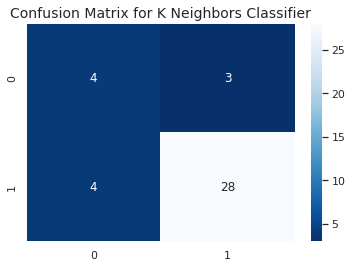

In [ ]:
# Confustion Matrix 
y_pred_classifier_KNN  = classifier_KNN.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred_classifier_KNN )
sns.heatmap(cf_matrix, annot=True, cmap="Blues_r")
plt.title("Confusion Matrix for K Neighbors Classifier", fontsize=14, fontname="Helvetica", y=1.03)